# U-Net Brain Tumor Segmentation

In [1]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib

import time

# Data augmentation
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, ElasticTransform, Rotate, RandomScale, GridDistortion, OpticalDistortion, OneOf
)

Using TensorFlow backend.


In [2]:
import datagen
import model as unet_model_script

In [3]:
# Reload lib contents
importlib.reload(datagen)
importlib.reload(unet_model_script)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

##  Hyperparemeters

In [4]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 15
image_size = 240
channels = 4
learning_rate = 1e-4 # 0.0001
# learning_rate = 5e-1 # 0.5
epochs = 250
batch_size = 8
dropout = False # 0.5
batch_norm = False

## Dataset

In [5]:
x_train, y_train = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='training', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=500,
                slices_w_less_brain=None,
                image_size=image_size,
                train_HGG_patients=train_HGG_patients)

training data with shape: (3585, 4, 240, 240) (3585, 1, 240, 240)


In [6]:
x_valid, y_valid = datagen.get_dataset(slices_from_patient, 
                file_path='../dataset/', 
                mode='validation', 
                glioma_type=['HGG'], 
                tumor_region=-1, 
                slices_w_tumor_only=False,
                slices_w_less_brain=None,
                image_size=240,
                train_HGG_patients=valid_HGG_patients)

validation data with shape: (300, 4, 240, 240) (300, 1, 240, 240)


## Model (U-Net)

### Optimizers

In [7]:
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, 
                                       beta_1=0.9, 
                                       beta_2=0.999)
sgd_optimizer = keras.optimizers.SGD(learning_rate=learning_rate, 
                                     momentum=0.5, 
                                     nesterov=True)

### Loses

In [8]:
def focal_loss(gamma=2., alpha=.25):
    '''
    Focal loss adapts the standard Cross entropy (CE) to deal with extreme foreground-background class imbalance, 
    where the loss assigned to well-classified examples is reduced.
    
    (source: https://medium.com/@junma11/loss-functions-for-medical-image-segmentation-a-taxonomy-cefa5292eec0)
    '''
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))        
        
#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(tf.clip_by_value(pt_1, 1e-20, 1e20))) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(tf.clip_by_value(1. - pt_0, 1e-20, 1e20)))
    return focal_loss_fixed


def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

def de_cce_loss(y_true, y_pred):
    """
    Combination of Dice Loss and Cross Entropy
    
    (source: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/)
    """
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return keras.losses.crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def de_focal_loss(y_true, y_pred):
    """
    Combination of Dice Loss and Cross Entropy
    
    (source: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/)
    """
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))
    
    def focal_loss_fixed(y_true, y_pred):
        gamma=2.
        alpha=.25
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))        
        
#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(tf.clip_by_value(pt_1, 1e-20, 1e20))) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(tf.clip_by_value(1. - pt_0, 1e-20, 1e20)))

    return focal_loss_fixed(y_true, y_pred) + dice_loss(y_true, y_pred)

In [9]:
model = unet_model_script.UNet(channels, image_size, dropout, batch_norm)
model.compile(optimizer=adam_optimizer,
              loss=dice_loss, # "categorical_crossentropy"
              metrics=["accuracy"]
             )

args: 4 240 False False
Compiled with input shape (None, 4, 240, 240) -- sigmoid


In [10]:
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
#     Rotate(limit=90, p=0.99),
#     RandomGamma(gamma_limit=(80, 120), p=0.25),
#     RandomScale(scale_limit=0.1, interpolation=cv2.INTER_NEAREST, p=0.25),
#     ElasticTransform(alpha=1, p=0.5),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#     ], p=0.2),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.5),
])

In [11]:
class Datagen(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.x_aug, self.y_aug = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_x = np.array(self.x_aug[idx * self.batch_size:(idx + 1) * self.batch_size])
        batch_y = np.array(self.y_aug[idx * self.batch_size:(idx + 1) * self.batch_size])            
        return batch_x, batch_y
    
    def on_epoch_end(self):
        data_x = []
        data_y = []
        
        if self.augment:
            for img, mask in zip(self.x, self.y):
                
                if np.count_nonzero(mask): # Final control if mask contains tumor labels
                    
                    try:
                        augmented = self.augment(image=img, mask=mask)
#                         print("Test print", img.shape, mask.shape)
                    except Exception as e:
#                         print(e)
                        f, axarr = plt.subplots(1,2)
                        axarr[0].imshow(img[0]) #, cmap='gray', vmin=0
                        axarr[1].imshow(mask[0], alpha=1)
                    data_x.append(augmented["image"])
                    data_y.append(augmented["mask"])
                else:
                    data_x.append(img)
                    data_y.append(mask)
        else:
            data_x, data_y = selg.x_aug, selg.y_aug
            
        self.x_aug = np.array(data_x)
        self.y_aug = np.array(data_y)

In [12]:
train_gen = Datagen(x_train, y_train, batch_size, AUGMENTATIONS)

Mask values: [0. 1. 2. 4.]
(240, 240) (240, 240)


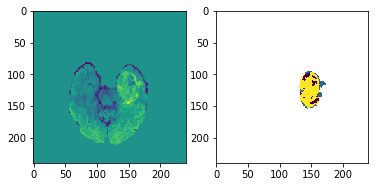

In [13]:
i = random.randint(0,238)
foo_x, foo_y = train_gen.__getitem__(i)
im = foo_x[0][0]
m = foo_y[0][0]

print("Mask values:", np.unique(m))

print(im.shape, m.shape)
m[m == 0] = np.nan

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im)
axarr[1].imshow(m, alpha=1)

- 4 U-Nety, paralelne pocitanie, fuzovanie vystupov do jedneho..
- pripadne skusit zretazit U-Nety priamo, treba osetrit LOSS Funkciou
- trenovanie --> skusit zastavit az Early stopom 
- do prace: systematicky vyhodnotit experimenty, ktore sa uvedu do prace.

------ vybrat si hyperparametre, ktore sa budu vyhodnocovat, na nich to nechat dlho trenovat a tieto experimenty budeme vyhodnocovat. Z toho vyjde zaver, co je najlepsia moznost

## Callbacks

In [14]:
callbacks = [
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', 
                                            min_delta=0.0001, 
                                            patience=100, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True),
#     TensorBoard(log_dir="logs/{}".format(time()))
]

# Training

In [ ]:
train_steps = train_HGG_patients * slices_from_patient
valid_steps = valid_HGG_patients * slices_from_patient

hist = model.fit(train_gen, validation_data=(x_valid, y_valid), epochs=4000, shuffle=True, callbacks=callbacks)

# hist = model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), 
#                     epochs=epochs, callbacks=callbacks, batch_size=batch_size)

# hist = model.fit_generator(train_gen, validation_data=(x_valid, y_valid), steps_per_epoch=train_steps,
#                     epochs=epochs, callbacks=callbacks)

# model.save("../models/2020040100.h5")

Epoch 1/4000
 90/449 [=====>........................] - ETA: 8:59 - loss: 0.3207 - accuracy: 0.6568

### Results

In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(x_valid, verbose=1)

In [ ]:
i = random.randint(0, 238)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_valid[i][0]) #, cmap='gray', vmin=0
axarr[1].imshow(y_valid[i][0]) #, cmap='gray', vmin=0
axarr[2].imshow(pred[i][0]) #, cmap='gray', vmin=0